In [1]:
import os
import time
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import statistics as s

def piec(s, l):
    fig1, ax1 = plt.subplots()
    ax1.pie(s, labels=l, autopct='%1.1f%%', startangle=90)
    ax1.axis('equal')
    plt.figure(figsize=(20,10)) 
    plt.show()

# apps

We have chosen 4 popular apps from Google Play:

In [2]:
apps = {
    'reddit' : {
        'id' : 'com.reddit.frontpage',
        'color' : 'darkred',
        'linestyle' : 'solid',
        'marker': 'tri_down'
    },
#     'snapchat': { # only has reviews from ~ August
#         'id' : 'com.snapchat.android',
#         'color': 'yellow',
#         'linestyle': 'dotted',
#         'linewidth': '1',
#         'marker': 'circle'
#     },
    'soundcloud': {
        'id' : 'com.soundcloud.android',
        'color': 'orange',
        'linestyle': 'solid',
        'linewidth': '1',
        'marker': 'circle'
    },
    'twitter': {
        'id' : 'com.twitter.android',
        'color': 'orange',
        'linestyle': 'solid',
        'linewidth': '1',
        'marker': 'circle'
    }
#     'whatsapp': { # only has reviews from ~ December
#         'id' : 'com.whatsapp',
#         'color': 'gray',
#         'linestyle': 'dotted',
#         'linewidth': '1',
#         'marker': 'circle'
#     }
}

# import

### [1] raw, cleaned, classified
For each app, we import preprocessed (cleaned) datasets, as well as _exportable_ datasets.
The cleaned datasets are datasets that:
- were collected by scraping Google Play
- have had null values removed
- have had replyDates converted to boolean (1 or 0 indicating whether a review was replied to)
- have had short/meaningless reviews removed
- have had their review content classified into columns: sentiment, category
- have the following structure:

<table style="text-align:left;float:left;border:1px solid green;">
    <tr>
        <th>Timestamp</th>
        <th>Username</th>
        <th>Rating</th>
        <th>Review</th>
        <th>Sentiment</th>
        <th>Category</th>
        <th>Words</th>
        <th>Chars</th>
        <th>Likes</th>
        <th>ReplyDate</th>
        <th>Year</th>
        <th>Month</th>
        <th>Weekday Name</th>
    </tr>
    <tr>
        <td>08-08-2019 16:20</td>
        <td>George</td>
        <td>5</td>
        <td>Great app for reasons A, B, and C</td>
        <td>1</td>
        <td>Other</td>
        <td>Words</td>
        <td>27</td>
        <td>0</td>
        <td>0</td>
        <td>2019</td>
        <td>August</td>
        <td>Wednesday</td>
    </tr>
</table>
<br><br><br>

### [2] exportable, daily sum totals
The exportable datasets have the following structure:

<table style="float:left;border:1px solid red;">
    <tr>
        <th>Time</th>
        <th>ReviewCount</th>
        <th>Rating</th>
        <th>Words</th>
        <th>Chars</th>
        <th>Replies</th>
        <th>Negative</th>
        <th>Neutral</th>
        <th>Positive</th>
        <th>ImprovementRequest</th>
        <th>BugReport</th>
        <th>Other</th>
    </tr>
    <tr>
        <td>31-01-2020 16:20</td>
        <td>540</td>
        <td>2394</td>
        <td>13200</td>
        <td>32193</td>
        <td>44</td>
        <td>1</td>
        <td>19</td>
        <td>45</td>
        <td>411</td>
        <td>30</td>
        <td>30</td>
    </tr>
</table>
<br><br><br><br>
The following step ('select 40 datapoints'), we do based on these exportable datasets, whose columns consist of the <strong>daily</strong> sum totals of reviews, bug reports, etc. Daily averages can easily be calculated from these values where needed.

However, to perform the subsequent step after the selection ('sampling'), we need to go back to the datasets as they were before being "collapsed" into daily sum totals. We have to:
- retrieve all reviews pertaining to the each bucket (tsadf, peaks, valleys, random)
- from those reviews, make a balanced sampling of 100 reviews

In [3]:
rcc = {} # raw, cleaned, classified dataset
edf = {} # exportable daily sum totals

for x in apps:
    rcc[x] = pd.read_csv('data/gplay_clean/' + x + '_raw_clean.csv',
                         index_col="Timestamp",
                         parse_dates=True).loc['2019']
    edf[x] = pd.read_csv('data/exported/' + x + '_clean_2019.csv')
    
print(rcc.keys(),'\n',edf.keys())

dict_keys(['reddit', 'soundcloud', 'twitter']) 
 dict_keys(['reddit', 'soundcloud', 'twitter'])


In [4]:
rcc['reddit'].head()

,Username,Rating,Review,Words,Chars,Likes,ReplyDate,Year,Month,Weekday Name
Timestamp,,,,,,,,,,
2019-12-31 23:36:53.970000+00:00,Robert Bolton,5,Watch hours of your life vanish with glee,8,41,0,0,2019,12,Tuesday
2019-12-31 23:31:41.285000+00:00,Sandra Thomas,5,Reddit is news and humanity! It's a conglomera...,12,79,0,0,2019,12,Tuesday
2019-12-31 23:13:55.547000+00:00,Garry Wells,5,My daily go to for news the concerns me.,9,40,0,0,2019,12,Tuesday
2019-12-31 23:05:32.200000+00:00,Andre Botha,4,Love the diversity of topics. Redditors have a...,12,70,0,0,2019,12,Tuesday
2019-12-31 22:16:40.141000+00:00,KWACKING DUCK,5,The best memeS EVERRRRRRR. I FREAKINGG LOOOVVV...,8,53,0,0,2019,12,Tuesday


In [5]:
edf['reddit'].head()

,Time,ReviewCount,Words,Chars,Likes,Rating,Avg_Words,Avg_Chars,Avg_Likes,Avg_Rating
0,01.01.2019 00:00,50,898,4751,186,191,17.96,95.02,3.72,3.82
1,02.01.2019 00:00,68,1016,5323,16,256,14.94,78.28,0.24,3.76
2,03.01.2019 00:00,47,657,3336,0,169,13.98,70.98,0.00,3.60
3,04.01.2019 00:00,55,1001,5349,26,187,18.20,97.25,0.47,3.40
4,05.01.2019 00:00,56,1087,5989,49,219,19.41,106.95,0.88,3.91


<Figure size 1440x1296 with 0 Axes>

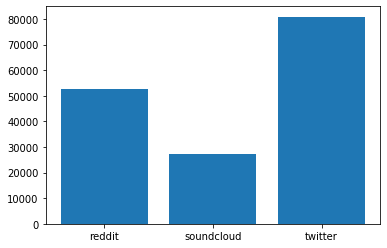

<Figure size 1440x1296 with 0 Axes>

In [6]:
sizes = []
titles = []
y_pos = np.arange(len(sizes))

for app in rcc.keys():
    titles.append(app)
    sizes.append(len(rcc[app]))

plt.bar(np.arange(len(sizes)), sizes)
plt.xticks(np.arange(len(sizes)), titles)
plt.figure(figsize=(20, 18))

<Figure size 1440x1296 with 0 Axes>

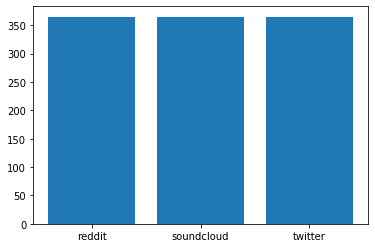

<Figure size 1440x1296 with 0 Axes>

In [7]:
sizes = []
titles = []
y_pos = np.arange(len(sizes))

for app in edf.keys():
    titles.append(app)
    sizes.append(len(edf[app]))

plt.bar(np.arange(len(sizes)), sizes)
plt.xticks(np.arange(len(sizes)), titles)
plt.figure(figsize=(20, 18))

In [8]:
# demonstrate that the daily sum totals are based on the raw
print(sum(edf['reddit']['ReviewCount']),
len(rcc['reddit']))

52562 52562


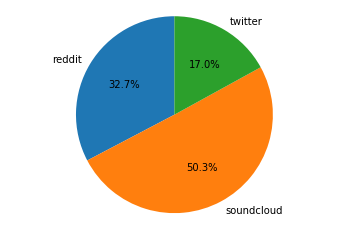

<Figure size 1440x720 with 0 Axes>

In [9]:
# distribution of reviews from raw/cleaned/classes
piec([len(rcc['reddit']), len(rcc['twitter']), len(rcc['soundcloud'])],
    rcc.keys())

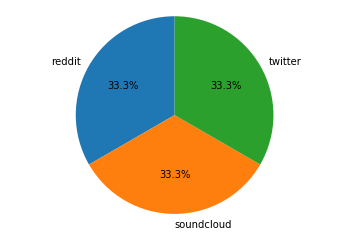

<Figure size 1440x720 with 0 Axes>

In [10]:
# distribution of reviews in exportable dataframes
piec([len(edf['reddit']), len(edf['twitter']), len(edf['soundcloud'])],
    edf.keys())

# select 40 (days) datapoints

In [11]:
def append_index2(selected, app, indices_to_select):
    """
    This method takes an arbitrary amount of (int) indices
    and appends the first 10 unique values to an array.
    """
    print('Start appending 10 unique values to the following array:')
    print(selected)
    
    selected_counter = 0
    duplicates = []
    
    # iterate over the provided indices
    for idx in indices_to_select:
        if selected_counter >= 10: # 10 values have been appended
            print("Reached 10 values, breaking..")
            break
        elif idx in selected: # duplicate value
            duplicates.append(idx)
            continue
        else: # unique value found
            selected.append(idx)
            selected_counter += 1
    
    if selected_counter < 10:
        print("Was not able to append 10 values due to duplicate values. These values are already selected:")
        print(duplicates)
    else:
        print(f"Successfully added 10 unique values for {app}")
        print(selected)
        # print the dates next to the indices
        sdates = []
        for idx in selected:
            sdates.append(get_date_via_idx(idx).split(" ")[0])
        print(sdates)
        
def get_date_via_idx(date):
    return edf['reddit'].iloc[date].Time

### 10 datapoints from time-series anomaly detection framework

In order to get the ten datapoints from the anomaly detection framework for each app, we simply load the exportable (anomaly detection framework compliant) datasets into the system, and have it output the indices of datapoints it thinks is anomalous.

This process is done manually, and the results are logged in the table below:

<table style="float: left;">
    <thead>
        <tr>
            <th>App</th>
            <th style="text-align: left;">Anomaly Indices</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>Reddit</td>
            <td id="reddit_indices">[58, 59, 88, 89, 103, 104, 114, 115, 127, 128, 144, 158, 171, 213, 204, 252]</td>
        </tr>
    </tbody>
</table>

In [12]:
selected_indices = {} # holds the selected indices of all apps
selected_indices['reddit'] = []
# reddit_tsadf_ind = [59, 88, 89, 103, 128, 144, 171, 213, 204, 252] # 3 words min
reddit_tsadf_idx = [59, 88, 104, 115, 127, 144, 158, 171, 252, 324] # 5 words min
append_index2(selected_indices['reddit'], 'reddit', reddit_tsadf_idx)

Start appending 10 unique values to the following array:
[]
Successfully added 10 unique values for reddit
[59, 88, 104, 115, 127, 144, 158, 171, 252, 324]
['01.03.2019', '30.03.2019', '15.04.2019', '26.04.2019', '08.05.2019', '25.05.2019', '08.06.2019', '21.06.2019', '10.09.2019', '21.11.2019']


### 10 datapoints from visual _peaks_

To get these ten datapoints, we plot the data for the whole year, and simply choose ten visible peaks.

In [13]:
s.mean(edf['reddit']['ReviewCount'])

144.0054794520548

In [14]:
len(rcc['reddit'])

52562

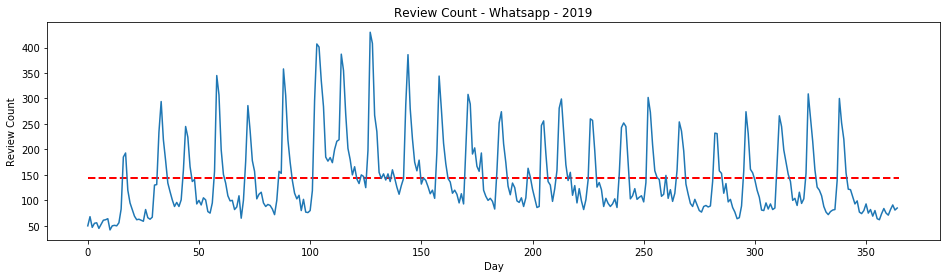

In [15]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(edf['reddit']['ReviewCount'])
ax.set(xlabel='Day', ylabel='Review Count', title='Review Count - Whatsapp - 2019')
plt.hlines(y=s.mean(edf['reddit']['ReviewCount']), xmin=0, xmax=len(edf['reddit']), colors='r', linestyles='--', lw=2)
plt.show()

In [16]:
print(f"Variance: {s.variance(edf['reddit'].ReviewCount)}",
f"Standard deviation: {s.stdev(edf['reddit'].ReviewCount)}")

Variance: 5536.7746951678455 Standard deviation: 74.4095067526176


In [17]:
above_mean = edf['reddit'][edf['reddit']['ReviewCount'] > s.mean(edf['reddit']['ReviewCount'])]['ReviewCount']
largest = np.array(above_mean)

peaks = largest[np.argsort(largest)[-50:]]
peaks

array([235, 236, 236, 237, 243, 245, 245, 245, 247, 252, 252, 252, 254,
       256, 257, 260, 262, 266, 267, 269, 273, 274, 274, 280, 280, 281,
       284, 286, 288, 289, 294, 296, 299, 300, 302, 306, 307, 308, 309,
       335, 344, 345, 355, 358, 386, 387, 401, 407, 408, 430])

In [19]:
# find the indices via the largest values
highest_indices = []
for high_idx in peaks:
    index = edf['reddit'][edf['reddit'].ReviewCount == high_idx].index[0]
    highest_indices.append(index)

In [20]:
append_index2(selected_indices['reddit'], 'reddit', highest_indices)

Start appending 10 unique values to the following array:
[59, 88, 104, 115, 127, 144, 158, 171, 252, 324]
Reached 10 values, breaking..
Successfully added 10 unique values for reddit
[59, 88, 104, 115, 127, 144, 158, 171, 252, 324, 130, 214, 73, 240, 44, 204, 185, 266, 205, 227]
['01.03.2019', '30.03.2019', '15.04.2019', '26.04.2019', '08.05.2019', '25.05.2019', '08.06.2019', '21.06.2019', '10.09.2019', '21.11.2019', '11.05.2019', '03.08.2019', '15.03.2019', '29.08.2019', '14.02.2019', '24.07.2019', '05.07.2019', '24.09.2019', '25.07.2019', '16.08.2019']


### 10 datapoints from visual _valleys_

In [21]:
# all datapoints below the mean
below_mean = edf['reddit'][edf['reddit']['ReviewCount'] < s.mean(edf['reddit']['ReviewCount'])]['ReviewCount']
smallest = np.array(below_mean)
# valleys
k = 50
valleys = np.argpartition(smallest, k)[:k]
valleys

array([ 45, 221,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  73,  64,   1, 166,  19,  20,  21,  22,  23, 177,  25,
        26,  27, 226, 225, 178, 223, 222,   0, 179, 219,  54, 217, 202,
       214, 203,  72, 213, 204,  44, 165, 185, 220,  74, 215])

In [23]:
append_index2(selected_indices['reddit'], 'reddit', valleys)

Start appending 10 unique values to the following array:
[59, 88, 104, 115, 127, 144, 158, 171, 252, 324, 130, 214, 73, 240, 44, 204, 185, 266, 205, 227]
Reached 10 values, breaking..
Successfully added 10 unique values for reddit
[59, 88, 104, 115, 127, 144, 158, 171, 252, 324, 130, 214, 73, 240, 44, 204, 185, 266, 205, 227, 45, 221, 2, 3, 4, 5, 6, 7, 8, 9]
['01.03.2019', '30.03.2019', '15.04.2019', '26.04.2019', '08.05.2019', '25.05.2019', '08.06.2019', '21.06.2019', '10.09.2019', '21.11.2019', '11.05.2019', '03.08.2019', '15.03.2019', '29.08.2019', '14.02.2019', '24.07.2019', '05.07.2019', '24.09.2019', '25.07.2019', '16.08.2019', '15.02.2019', '10.08.2019', '03.01.2019', '04.01.2019', '05.01.2019', '06.01.2019', '07.01.2019', '08.01.2019', '09.01.2019', '10.01.2019']


### 10 random datapoints

Here we do a random sample (with varying seed), and make sure to only select indices that have not been selected by previous steps.

np.random.random_sample(10)

In [24]:
random_sel = random.sample(list(edf['reddit'].index), 30)
append_index2(selected_indices['reddit'], 'reddit', random_sel)

Start appending 10 unique values to the following array:
[59, 88, 104, 115, 127, 144, 158, 171, 252, 324, 130, 214, 73, 240, 44, 204, 185, 266, 205, 227, 45, 221, 2, 3, 4, 5, 6, 7, 8, 9]
Reached 10 values, breaking..
Successfully added 10 unique values for reddit
[59, 88, 104, 115, 127, 144, 158, 171, 252, 324, 130, 214, 73, 240, 44, 204, 185, 266, 205, 227, 45, 221, 2, 3, 4, 5, 6, 7, 8, 9, 39, 272, 217, 174, 157, 228, 133, 122, 321, 72]
['01.03.2019', '30.03.2019', '15.04.2019', '26.04.2019', '08.05.2019', '25.05.2019', '08.06.2019', '21.06.2019', '10.09.2019', '21.11.2019', '11.05.2019', '03.08.2019', '15.03.2019', '29.08.2019', '14.02.2019', '24.07.2019', '05.07.2019', '24.09.2019', '25.07.2019', '16.08.2019', '15.02.2019', '10.08.2019', '03.01.2019', '04.01.2019', '05.01.2019', '06.01.2019', '07.01.2019', '08.01.2019', '09.01.2019', '10.01.2019', '09.02.2019', '30.09.2019', '06.08.2019', '24.06.2019', '07.06.2019', '17.08.2019', '14.05.2019', '03.05.2019', '18.11.2019', '14.03.2019

In [25]:
len(selected_indices['reddit'])

40

# from INDICES to DATES

In [26]:
import re
dates = []

for i in selected_indices['reddit']:
    date = edf['reddit'][edf['reddit'].index == i].Time
    
    cl = re.sub(" 00:00", "", date.item()) # remove trailing 00:00
    sp = cl.split(".")
    cl = sp[1] + "-" + sp[0] + "-" + sp[2] # change order to MONTH / DAY / YEAR
    dates.append(cl)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: `item` has been deprecated and will be removed in a future version
  import sys


# selecting 100 reviews per datapoint from the (above) four buckets

At this point, we have selected 10 unique datapoints (days, dates) from the following four buckets:
- tsadf
- peaks
- valleys
- random

We've made sure the selected data points are unique.

The next step is to iterate through all (in total) 40 datapoints, and from each date, select (at least) 100 reviews. In the end, we should be left with a maximum of 4000 reviews from each app.

(Remark 1) Each app has several tens of thousands of reviews, however we cannot always be sure that each selected datapoint (date) has 100 reviews. For datasets with less than 100K reviews, this may often be the case.

We iterate through each date, and then perform a stratified sample of 100 reviews based on the rating (1-5), so that the selected 100 reviews are representative of all the reviews that were written on that date.

(Remark 2) To perform the stratified sample, we make use of ScikitLearn 'SplitTrainTest' method, which accepts a percentage that indicates how large the _test_ set should be. As we want _exactly_ 100 reviews, we have to calculate how much 100 reviews is in percent, with respect to the reviews in the given datapoint.

Finding the percentage 100 is of AMOUNT_OF_REVIEWS = (100 / REVIEW_COUNT) * 100 

Considering Remark 1, we do this wherever possible. If it is not possible, we simply take the reviews that are there.

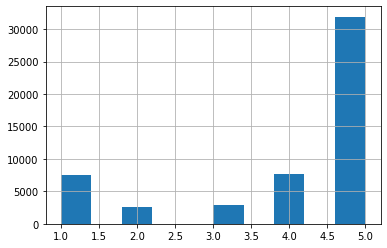

In [27]:
# distribution of rating across ENTIRE dataset
rcc['reddit']['Rating'].hist()

In [28]:
rcc['reddit']['Rating'].value_counts() / len(rcc['reddit'])

5    0.606940
4    0.146608
1    0.142479
3    0.055668
2    0.048305
Name: Rating, dtype: float64

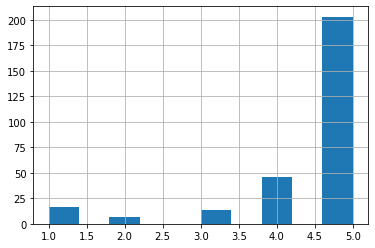

In [29]:
# distribution of rating on a given date
rcc['reddit']['Rating'].loc[dates[-1]].hist()

In [30]:
# rating ratio on a given date
rcc['reddit']['Rating'].loc[dates[1]].value_counts() / len(rcc['reddit'].loc[dates[1]])

5    0.675978
4    0.203911
3    0.050279
1    0.050279
2    0.019553
Name: Rating, dtype: float64

# final touches

The dataframe 'rcc' (cleaned reviews) is the one we pipe into an Excel sheet.

However, we only need a few columns, also, ReplyDate is a boolean field.

In [31]:
rcc['reddit'].head(1)

,Username,Rating,Review,Words,Chars,Likes,ReplyDate,Year,Month,Weekday Name
Timestamp,,,,,,,,,,
2019-12-31 23:36:53.970000+00:00,Robert Bolton,5,Watch hours of your life vanish with glee,8,41,0,0,2019,12,Tuesday


In [32]:
rcc2 = rcc.copy()

rcc2['reddit'] = rcc2['reddit'].drop(['Username', 'Words', 'Chars', 'Year', 'Month', 'Weekday Name'], axis=1)
rcc2['reddit'].head(1)

,Rating,Review,Likes,ReplyDate
Timestamp,,,,
2019-12-31 23:36:53.970000+00:00,5,Watch hours of your life vanish with glee,0,0


In [33]:
rcc2['reddit'] = rcc2['reddit'].rename(columns = {
    "ReplyDate": "Reply?"
}, errors="raise")
rcc2['reddit'].head(1)

,Rating,Review,Likes,Reply?
Timestamp,,,,
2019-12-31 23:36:53.970000+00:00,5,Watch hours of your life vanish with glee,0,0


In [34]:
# make new dataframe to hold our samples from each date
selected_reviews = pd.DataFrame(columns=rcc2['reddit'].columns)
selected_reviews.head()

,Rating,Review,Likes,Reply?


In [35]:
from sklearn.model_selection import StratifiedShuffleSplit

def get_strat_sample(app, date):
    reviews_on_date = rcc2[app].loc[date]
    ratings_on_date = reviews_on_date['Rating']

    pct_100 = (100 / len(reviews_on_date))
    
    print(f"({date}) 100 reviews in % of {len(reviews_on_date)}: {round((pct_100 * 100), 2)}%")
    
    split = StratifiedShuffleSplit(n_splits=1, test_size=pct_100, random_state=23)
    for train_index, test_index in split.split(reviews_on_date, ratings_on_date):
        strat_train_set = reviews_on_date.iloc[train_index]
        strat_test_set = reviews_on_date.iloc[test_index]

    return strat_test_set
        
test = get_strat_sample('reddit', '2019-03-01')
test

(2019-03-01) 100 reviews in % of 307: 32.57%


,Rating,Review,Likes,Reply?
Timestamp,,,,
2019-03-01 23:42:58.740000+00:00,4,I enjoy reddit and all the different categorie...,0,0
2019-03-01 17:38:04.986000+00:00,4,"I like the content, but the app has issues. No...",2,0
2019-03-01 02:40:37.388000+00:00,4,"Decent app, only complain is probably the comm...",0,0
2019-03-01 09:55:01.700000+00:00,5,very informative on many different aspects...,1,0
2019-03-01 22:44:14.587000+00:00,5,"very fun to use, many different communities to...",0,0
...,...,...,...,...
2019-03-01 11:44:15.976000+00:00,5,Works fairly well as an application.,0,0
2019-03-01 09:48:22.518000+00:00,4,can be a lot better and practical but still i ...,0,0
2019-03-01 19:37:18.616000+00:00,5,i got 4th level cancer in one week and have 3 ...,0,0


In [36]:
test['Rating'].value_counts() / len(test)

5    0.72
4    0.18
1    0.05
3    0.03
2    0.02
Name: Rating, dtype: float64

In [37]:
rcc['reddit']['Rating'].loc['2019-03-01'].value_counts() / len(rcc['reddit'].loc['2019-03-01'])

5    0.723127
4    0.175896
1    0.048860
3    0.035831
2    0.016287
Name: Rating, dtype: float64

It is demonstrated in the two above cells that the ratio of the rating in the (stratified, "test set") sample is close to identical with that found in the whole collection of reviews on the date from which reviews were sampled.

In [38]:
lt_100_counter = 0
for date in dates:
    data = rcc2['reddit'].loc[date]
    if len(data) < 110: # technically there only has to be 100 reviews present, but it turns out
                        # the SplitStratified (scikit.learn) needs a little wiggleroom (~10 reviews)
        print(f'For date: {date} found LT 100 reviews ({len(data)}). Selecting all')
        lt_100_counter += 1
        sample = data
    else:
        print(f'For date: {date} found GT 100 reviews ({len(data)}). Performing strat sample')
        sample = get_strat_sample('reddit', date)
        
    for idx, row in sample.iterrows():
        selected_reviews.loc[idx] = row
        
if lt_100_counter != 0:
    print(f"{lt_100_counter}/40 days did not have 100 reviews")
else:
    print("All days had at least 100 reviews")
print(f"{len(selected_reviews)} reviews selected from {len(dates)} unique dates")

For date: 03-01-2019 found GT 100 reviews (307). Performing strat sample
(03-01-2019) 100 reviews in % of 307: 32.57%
For date: 03-30-2019 found GT 100 reviews (358). Performing strat sample
(03-30-2019) 100 reviews in % of 358: 27.93%
For date: 04-15-2019 found GT 100 reviews (401). Performing strat sample
(04-15-2019) 100 reviews in % of 401: 24.94%
For date: 04-26-2019 found GT 100 reviews (355). Performing strat sample
(04-26-2019) 100 reviews in % of 355: 28.17%
For date: 05-08-2019 found GT 100 reviews (430). Performing strat sample
(05-08-2019) 100 reviews in % of 430: 23.26%
For date: 05-25-2019 found GT 100 reviews (386). Performing strat sample
(05-25-2019) 100 reviews in % of 386: 25.91%
For date: 06-08-2019 found GT 100 reviews (344). Performing strat sample
(06-08-2019) 100 reviews in % of 344: 29.07%
For date: 06-21-2019 found GT 100 reviews (308). Performing strat sample
(06-21-2019) 100 reviews in % of 308: 32.47%
For date: 09-10-2019 found GT 100 reviews (302). Perform

In [41]:
selected_reviews.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3614 entries, 2019-03-01 23:42:58.740000+00:00 to 2019-03-14 04:12:45.192000+00:00
Data columns (total 4 columns):
Rating    3614 non-null object
Review    3614 non-null object
Likes     3614 non-null object
Reply?    3614 non-null object
dtypes: object(4)
memory usage: 141.2+ KB


In [42]:
selected_reviews['Review'][selected_reviews['Reply?'] == 1]

2019-02-14 18:20:46.850000+00:00    How do you get on incognito... err asking for ...
Name: Review, dtype: object

# build xlsx

In [43]:
m_d_y_dates = dates
y_m_d_dates = []
for date in m_d_y_dates:
    arr = date.split("-")
    m = arr[0]
    d = arr[1]
    y = arr[2]
    ymd = y + '-' + m + '-' + d
    y_m_d_dates.append(ymd)
    print(f"MM-DD-YYYY: {date}, YYYY-DD-MM: {ymd}")
    
def get_ymd_date(date):
    arr = date.split("-")
    m = arr[0]
    d = arr[1]
    y = arr[2]
    ymd = y + '-' + m + '-' + d
    return ymd

MM-DD-YYYY: 03-01-2019, YYYY-DD-MM: 2019-03-01
MM-DD-YYYY: 03-30-2019, YYYY-DD-MM: 2019-03-30
MM-DD-YYYY: 04-15-2019, YYYY-DD-MM: 2019-04-15
MM-DD-YYYY: 04-26-2019, YYYY-DD-MM: 2019-04-26
MM-DD-YYYY: 05-08-2019, YYYY-DD-MM: 2019-05-08
MM-DD-YYYY: 05-25-2019, YYYY-DD-MM: 2019-05-25
MM-DD-YYYY: 06-08-2019, YYYY-DD-MM: 2019-06-08
MM-DD-YYYY: 06-21-2019, YYYY-DD-MM: 2019-06-21
MM-DD-YYYY: 09-10-2019, YYYY-DD-MM: 2019-09-10
MM-DD-YYYY: 11-21-2019, YYYY-DD-MM: 2019-11-21
MM-DD-YYYY: 05-11-2019, YYYY-DD-MM: 2019-05-11
MM-DD-YYYY: 08-03-2019, YYYY-DD-MM: 2019-08-03
MM-DD-YYYY: 03-15-2019, YYYY-DD-MM: 2019-03-15
MM-DD-YYYY: 08-29-2019, YYYY-DD-MM: 2019-08-29
MM-DD-YYYY: 02-14-2019, YYYY-DD-MM: 2019-02-14
MM-DD-YYYY: 07-24-2019, YYYY-DD-MM: 2019-07-24
MM-DD-YYYY: 07-05-2019, YYYY-DD-MM: 2019-07-05
MM-DD-YYYY: 09-24-2019, YYYY-DD-MM: 2019-09-24
MM-DD-YYYY: 07-25-2019, YYYY-DD-MM: 2019-07-25
MM-DD-YYYY: 08-16-2019, YYYY-DD-MM: 2019-08-16
MM-DD-YYYY: 02-15-2019, YYYY-DD-MM: 2019-02-15
MM-DD-YYYY: 0

In [48]:
for d in y_m_d_dates:
    print(d)

2019-03-01
2019-03-30
2019-04-15
2019-04-26
2019-05-08
2019-05-25
2019-06-08
2019-06-21
2019-09-10
2019-11-21
2019-05-11
2019-08-03
2019-03-15
2019-08-29
2019-02-14
2019-07-24
2019-07-05
2019-09-24
2019-07-25
2019-08-16
2019-02-15
2019-08-10
2019-01-03
2019-01-04
2019-01-05
2019-01-06
2019-01-07
2019-01-08
2019-01-09
2019-01-10
2019-02-09
2019-09-30
2019-08-06
2019-06-24
2019-06-07
2019-08-17
2019-05-14
2019-05-03
2019-11-18
2019-03-14


In [44]:
writer = pd.ExcelWriter('data/excel/reddit.xlsx', engine='xlsxwriter')

In [45]:
selected = selected_reviews.copy()
selected.index = selected.index.tz_localize(None)

c = 1
for date in dates:
    selected.loc[date].to_excel(writer, sheet_name=get_ymd_date(date))
    c += 1
    
writer.save()